<a href="https://colab.research.google.com/github/fjme95/aplicaciones-financieras/blob/main/Modulo%202/Semana%203/LSTM_Bitcoin_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descripción del problema

Datos originales: https://challengedata.ens.fr/participants/challenges/31/

> The problem is a classification challenge that aims at building investment strategies on cryptocurrencies based on sentiment extracted from news and social networks.

> For each trading hour we have counted the occurence of some terms like for example "adoption" or "hack" in a selected number of influential twitter accounts as in some forums like Bitcointalk. We have created 10 different themes, some positives and others negatives and we summed the counts of the words corresponding, before normalising them. For a given sample and a given theme we use the counts of each of the 48 last hours, we Z scored these counts, and we multiplied the result by the average hourly count during the period divided by the average hourly count during all the training period. For a theme T in timestamp i, with lag k ($k\in[\![0;47]\!]$) the value F of the feature will be:

$$
F_{i,k}=\frac{T_{i,k}-\overline{T_{i}}}{\sqrt{\frac{1}{47}\sum\limits_{j=0}^{47}{(T_{i,j}-\overline{T_{i}})^{2}}}}*\frac{\overline{T_i}}{\overline{T}} 
$$

> We added 5 features corresponding to the price return of the last hour, the last 6 hours, the last 12 hours, the last 24 hours and the last 48 hours normalised by the volatility during the 48 hours. The aim is to predict if the return of Bitcoin in the next hour will be more than 0.2%, between -0.2% and 0.2%, or less than -0.2%. The 0.2% level is the 66.7% percentile of the distribution.

> The metric used for this problem is the logistic loss, defined as the negative log-likelyhood of the true labels given the classifier's predictions. The true labels are encoded as a 1-of-3 binary indicator matrix Y, ie $y_{i,k}=1'$ if sample i has label k taken from a set of 3 labels ( less than -0.2%, between -0.2% and +0.2%, more than 0.2%). For P a matrix of probability estimates with $p_{i,k}=Pr(t_{i,k}=1)'$ , the log loss function is defined as

$$
L_{log}(Y,P)=-log{Pr(Y|P)}=-\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^3{y_{i,k}log(p_{i,k})}
$$

>The lower the score, the better.



# Dependencias

In [ ]:
!pip install -U plotly

     |████████████████████████████████| 26.5 MB 1.6 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers

import plotly.graph_objects as go

# Funciones

In [ ]:
def evaluate_model(estimator, train, val, test):
    print('train cross_entropy = ', estimator.evaluate(train[0], train[1], verbose = False))
    print('  val cross_entropy = ', estimator.evaluate(val[0], val[1], verbose = False))
    print(' test cross_entropy = ', estimator.evaluate(test[0], test[1], verbose = False))

In [ ]:
# TODO: Modificar para seleccionar características cambiando n_features, no sólo las primeras n_features
# TODO: Revisar los resultados generados cuando se seleccionan distintos parámetros
# NOTE: Asume que el dataframe tiene 5 X, y 48 columnas para cada una de las 10 I ordenadas de reciente a antigua
def transform_dataframe(df, len_prices = 5, n_features = 10, len_features = 48):
    if type(len_prices) != int or type(n_features) != int or type(len_features) != int:
        raise ValueError(f'Los parámetros len_prices, n_features y len_features deben ser de tipo int. Recibibo {type(len_prices)},{type(n_features)} y {type(len_features)}')

    assert 0 < len_prices <= 5, 'len_prices debe estar entre 1 y 5'
    assert 0 < n_features <= 10, 'n_features debe estar entre 1 y 10'
    assert 0 < len_features <= 48, 'len_features debe estar entre 1 y 48'

    df.reset_index(inplace = True, drop = True)
    
    # Los nombres de las columnas están al reves para tener primer la observación más antigua
    prices_cols = ['X5', 'X4', 'X3', 'X2', 'X1']

    prices = np.zeros((len(df), len_prices, 1))
    features = np.zeros((len(df), len_features, n_features))

    for i in range(len(df)):
        # Se transforman la forma de los precios
        prices[i] = df.loc[i, prices_cols[-len_prices:]].values.reshape((len_prices, 1))
        # Para cada característica
        for j in range(n_features):
            # Se obtiene los 48 rezagos y se voltea el arreglo para tener el más antiguo primero
            # Aquí se aplica el supuesto de que el dataframe tiene 5 columnas de 5
            features[i, :, j] = np.flip(df.iloc[i, 5+48*j:5+len_features + 48*j].values)
    return prices, features

# Datos

> The Input data contains 10 time series of 48 trading hours representing complementary features based on sentiment analysis from news extracted from twitter or forums like Bitcointalk on Bitcoin, and 5 time series based on the variation of Bitcoin price during the past 1, 6, 12, 24 and 48 hours normalised by volatility during the period. Input data, for training and testing, will be given by a .csv file, whose first line contains the header. Then each line corresponds to a sample, each column to a feature. The features are the following:

>- ***ID***: Id of the sample which is linked to the ID of the output file;
- ***I_1_lag(k)*** to ***I_10_lag(k)***: Values of Indicators *I_1* to *I_10* for each k lag ($k\in[\![0;47]\!]$) representing the normalized value of Indicators *I_1* to *I_10* each hour of the past 48 trading hours;
- ***X_1*** to ***X_5***: Values of 5 normalised indicators representing price variation of Bitcoin on the last 1, 6, 12, 24 and 48 hours.

> There will be 14 000 samples for the train set and 5 000 for the test set. For a given sample, the time series (for the 10 sentiment indicators) are given over the same 48 trading hours.

>The training outputs are given in a .csv file. Each line corresponds to a sample:

>- ***ID***: Id of the sample;
- ***Target_-1***: classification of the return of Bitcoin in the next hour. -1 signifies a down move of less than -0.2%;
- ***Target_0***: classification of the return of Bitcoin in the next hour. 0 signifies a move between -0.2% and 0.2%;
- ***Target_1***: classification of the return of Bitcoin in the next hour. 1 signifies a up move of more than 0.2%.



In [ ]:
!gdown --id 1ChInKWKRi_jzyILWD3jQfL76RJI6E0TC
!gdown --id 1TCrtZYQEA1srivYLgH4hch29W4rn7z93

Downloading...
From: https://drive.google.com/uc?id=1ChInKWKRi_jzyILWD3jQfL76RJI6E0TC
To: /content/output_training_F2dZW38.csv
100% 171k/171k [00:00<00:00, 59.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TCrtZYQEA1srivYLgH4hch29W4rn7z93
To: /content/input_training_IrTAw7w.csv
100% 84.7M/84.7M [00:00<00:00, 103MB/s] 


In [ ]:
X_raw = pd.read_csv('/content/input_training_IrTAw7w.csv').set_index('ID')
X_raw

,X1,X2,X3,X4,X5,I1_lag0,I1_lag1,I1_lag2,I1_lag3,I1_lag4,I1_lag5,I1_lag6,I1_lag7,I1_lag8,I1_lag9,I1_lag10,I1_lag11,I1_lag12,I1_lag13,I1_lag14,I1_lag15,I1_lag16,I1_lag17,I1_lag18,I1_lag19,I1_lag20,I1_lag21,I1_lag22,I1_lag23,I1_lag24,I1_lag25,I1_lag26,I1_lag27,I1_lag28,I1_lag29,I1_lag30,I1_lag31,I1_lag32,I1_lag33,I1_lag34,...,I10_lag8,I10_lag9,I10_lag10,I10_lag11,I10_lag12,I10_lag13,I10_lag14,I10_lag15,I10_lag16,I10_lag17,I10_lag18,I10_lag19,I10_lag20,I10_lag21,I10_lag22,I10_lag23,I10_lag24,I10_lag25,I10_lag26,I10_lag27,I10_lag28,I10_lag29,I10_lag30,I10_lag31,I10_lag32,I10_lag33,I10_lag34,I10_lag35,I10_lag36,I10_lag37,I10_lag38,I10_lag39,I10_lag40,I10_lag41,I10_lag42,I10_lag43,I10_lag44,I10_lag45,I10_lag46,I10_lag47
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.460020,0.620360,-0.972192,2.745197,4.177783,2.325865,2.060138,0.071162,2.360597,-0.611526,-0.474029,1.380300,0.160847,1.101279,-1.064275,0.247346,-1.570320,0.490027,-0.621964,-1.221890,-0.732714,-0.078984,0.061406,0.221455,-0.355269,0.078437,0.976421,0.071217,-0.303876,1.760369,0.209699,1.055768,1.551331,-0.377121,-0.703104,-1.078121,-1.084246,0.907088,0.251208,-0.841226,...,-0.637173,-0.513893,0.015092,-0.429889,-0.462246,-0.605788,-0.065968,-0.310555,-0.427917,0.017064,0.268322,-0.135628,0.164521,1.230382,0.475606,1.819093,1.457144,0.272268,0.342204,-0.063995,-0.179603,-0.605788,-0.256935,-0.194165,-0.309554,-0.322650,-0.530428,-0.474835,-0.681148,-0.311526,-0.342912,-0.194165,0.122331,0.028682,-0.093626,-0.559840,0.562584,-0.557868,1.424906,-0.016294
1,-0.347872,-2.199925,-0.222026,3.741888,8.608291,-4.091293,-3.502499,-1.463631,0.383153,-3.669962,-2.118337,-0.933734,0.279289,-2.170922,-0.578250,1.221512,1.469743,2.237671,1.145432,3.997874,0.425221,-1.448649,-1.544079,-1.697530,-2.300471,-0.326959,-2.621576,-1.438986,-3.016570,-3.307165,-1.890347,-1.933800,-2.355512,-1.368035,3.060146,2.400343,-0.887212,-0.574003,3.272423,1.969621,...,1.519025,-0.100023,1.318612,-1.769285,-0.099151,-0.742011,-0.764704,3.114075,-0.768659,-1.888611,-4.173557,-1.500642,-1.281869,-0.307040,0.484154,0.513884,-1.375002,0.700223,2.471160,-0.529024,-3.761279,-1.292754,2.304832,1.712529,1.879730,2.607232,4.955086,3.848342,3.056587,0.446149,1.261341,-0.082428,-1.035813,-0.249607,-0.971215,-0.058408,1.460632,-0.653394,-1.743487,4.065305
2,-2.152963,-0.432461,1.619057,-0.003912,3.870262,-0.598858,-0.412391,-0.765354,-0.998152,-0.938755,-0.890084,-0.435971,-0.589324,-1.261406,-1.702031,-0.749754,-0.935591,-0.539690,-0.281132,-0.106126,-0.131812,1.365607,-0.247970,-0.618311,0.455266,-0.493096,0.019743,1.187119,2.071983,-0.242272,0.949171,0.478886,-0.528869,-0.723906,-0.486781,-0.552184,-0.777914,0.479526,-0.247711,-0.133604,...,-0.831661,-1.022850,-1.036608,-0.844501,-0.474288,-1.024714,-0.910107,-0.615287,-0.147307,-0.702378,-0.778221,0.429250,-0.189770,0.168520,0.351721,0.702135,-0.492046,0.513999,-0.262831,0.355271,-0.377906,-0.099897,-0.106679,-0.430878,-0.735757,-0.186989,-0.117655,-0.939759,0.238060,-0.352254,2.245204,3.002347,2.674186,2.656251,1.062974,-0.484619,-0.044594,1.579731,0.962836,1.146983
3,-1.827669,-1.881770,-4.214322,0.178225,0.992362,0.383757,2.512478,-0.383434,-0.208506,-1.104289,-1.055666,-1.792361,-1.313026,-1.183724,-2.461788,-1.905122,-2.562135,-1.307096,-0.598499,-2.498382,-3.018896,-2.769343,0.975802,1.980034,1.178934,1.533094,0.321730,0.999047,3.888724,3.225654,1.950678,2.240602,1.731966,1.678903,0.843741,-1.604130,0.207124,0.554533,-0.589924,1.096136,...,-2.773947,-2.241666,-0.501592,-3.224021,-0.692138,-1.462365,-1.964202,-0.243791,-1.411816,-1.045186,0.742529,1.240860,-0.149391,-0.430394,4.077533,2.034854,-0.604751,3.734104,0.801305,1.352424,-1.391221,-0.497520,-0.236622,-1.053379,0.706517,-1.464426,0.517342,-1.106200,-0.248532,-1.879933,1.383203,-1.338892,0.298076,1.808275,2.837975,2.054112,0.741138,1.701911,0.110082,0.114980
4,0.748761,1.799939,1.561006,5.204120,2.161637,-1.275226,-1.544131,-1.802590,-1.128526,-0.469835,-1.03

In [ ]:
y_raw = pd.read_csv('/content/output_training_F2dZW38.csv').set_index('ID')
y_raw

,Target -1,Target 0,Target 1
ID,,,
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
13995,0,0,1
13996,0,1,0
13997,0,1,0


## División: Entrenamiento, Validación y Prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size = .8, random_state = 10, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = .75, random_state = 10, shuffle = False)

print('     Train shape', X_train.shape)
print('Validation shape', X_val.shape)
print('      Test shape', X_test.shape)

     Train shape (8400, 485)
Validation shape (2800, 485)
      Test shape (2800, 485)


## Transformaciones

In [ ]:
len_prices = 5
n_features = 10
len_features = 48

train_prices, train_features = transform_dataframe(X_train, len_prices, n_features, len_features)
val_prices, val_features     = transform_dataframe(X_val,   len_prices, n_features, len_features)
test_prices, test_features   = transform_dataframe(X_test,  len_prices, n_features, len_features)

In [ ]:
print('        Labels: (samples, sequence length, features)')
print('  Train prices:', train_prices.shape)
print('Train features:', train_features.shape)

        Labels: (samples, sequence length, features)
  Train prices: (8400, 5, 1)
Train features: (8400, 48, 10)


# Algoritmos-Modelos

## Regresión logística

El punto de referencia de los propietarios de los datos es una regresión logística tomando como características X1, $\dots$, X5.

**Ejercicio**: Entrenar una regresión logística y evaluar el modelo obteniendo la pérdida logística (entropía cruzada). El valor esperado para esta métrica es de $1.1005$.

## Redes Neuronales

### Callbacks

In [ ]:
# Los guarda en GoogleDrive, si no se quiere hacer la conexión, entonces cambiar la ruta o quitar el callback
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     filepath = 'drive/MyDrive/Cursos/LSTM - Bitcoin v2/checkpoints', 
#     save_best_only = True
# )

earlystop_cb = keras.callbacks.EarlyStopping(
    patience = 25, 
    restore_best_weights = True
)

### Primera Aquitectura

#### Aquitectura

In [ ]:
price_input = layers.Input(shape = (len_prices, 1), name = 'price_input')
price_normalization = layers.Normalization(name = 'price_normalization', axis = 1)
price_lstm = layers.LSTM(16, name = 'price', 
                         kernel_regularizer=keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                         return_state=True, 
                         )

price_normalized = price_normalization(price_input)
price_output, price_h, price_c = price_lstm(price_normalized)

sentiment_input = layers.Input(shape = (len_features, n_features), name = 'sentiment_input')
sentiment_normalization = layers.Normalization(name = 'sentiment_normalization', axis = 1)
sentiment_lstm = layers.LSTM(16, 
                             name = 'sentiment', 
                             kernel_regularizer=keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-3), 
                             dropout = .3
                             )

sentiment_normalized = sentiment_normalization(sentiment_input)
sentiment_output = sentiment_lstm(sentiment_normalized, initial_state = [price_h, price_c])

fusion = layers.Concatenate(name = 'fusion')([sentiment_output, price_output])


prediction_layer = keras.models.Sequential(
    [
     layers.Dense(32, activation = 'sigmoid'), 
     layers.Dense(32, activation = 'sigmoid'), 
     layers.Dense(32, activation = 'sigmoid'), 
     layers.Dense(3, activation = 'softmax')
    ], 
    name = 'prediction'
)
prediction_output = prediction_layer(fusion)


#### Modelo

In [ ]:

model = keras.Model([price_input, sentiment_input], prediction_output)

model.compile(
    loss = 'categorical_crossentropy'
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 price_input (InputLayer)       [(None, 5, 1)]       0           []                               
                                                                                                  
 sentiment_input (InputLayer)   [(None, 48, 10)]     0           []                               
                                                                                                  
 price_normalization (Normaliza  (None, 5, 1)        11          ['price_input[0][0]']            
 tion)                                                                                            
                                                                                                  
 sentiment_normalization (Norma  (None, 48, 10)      97          ['sentiment_input[0][0]']    

##### Visualización

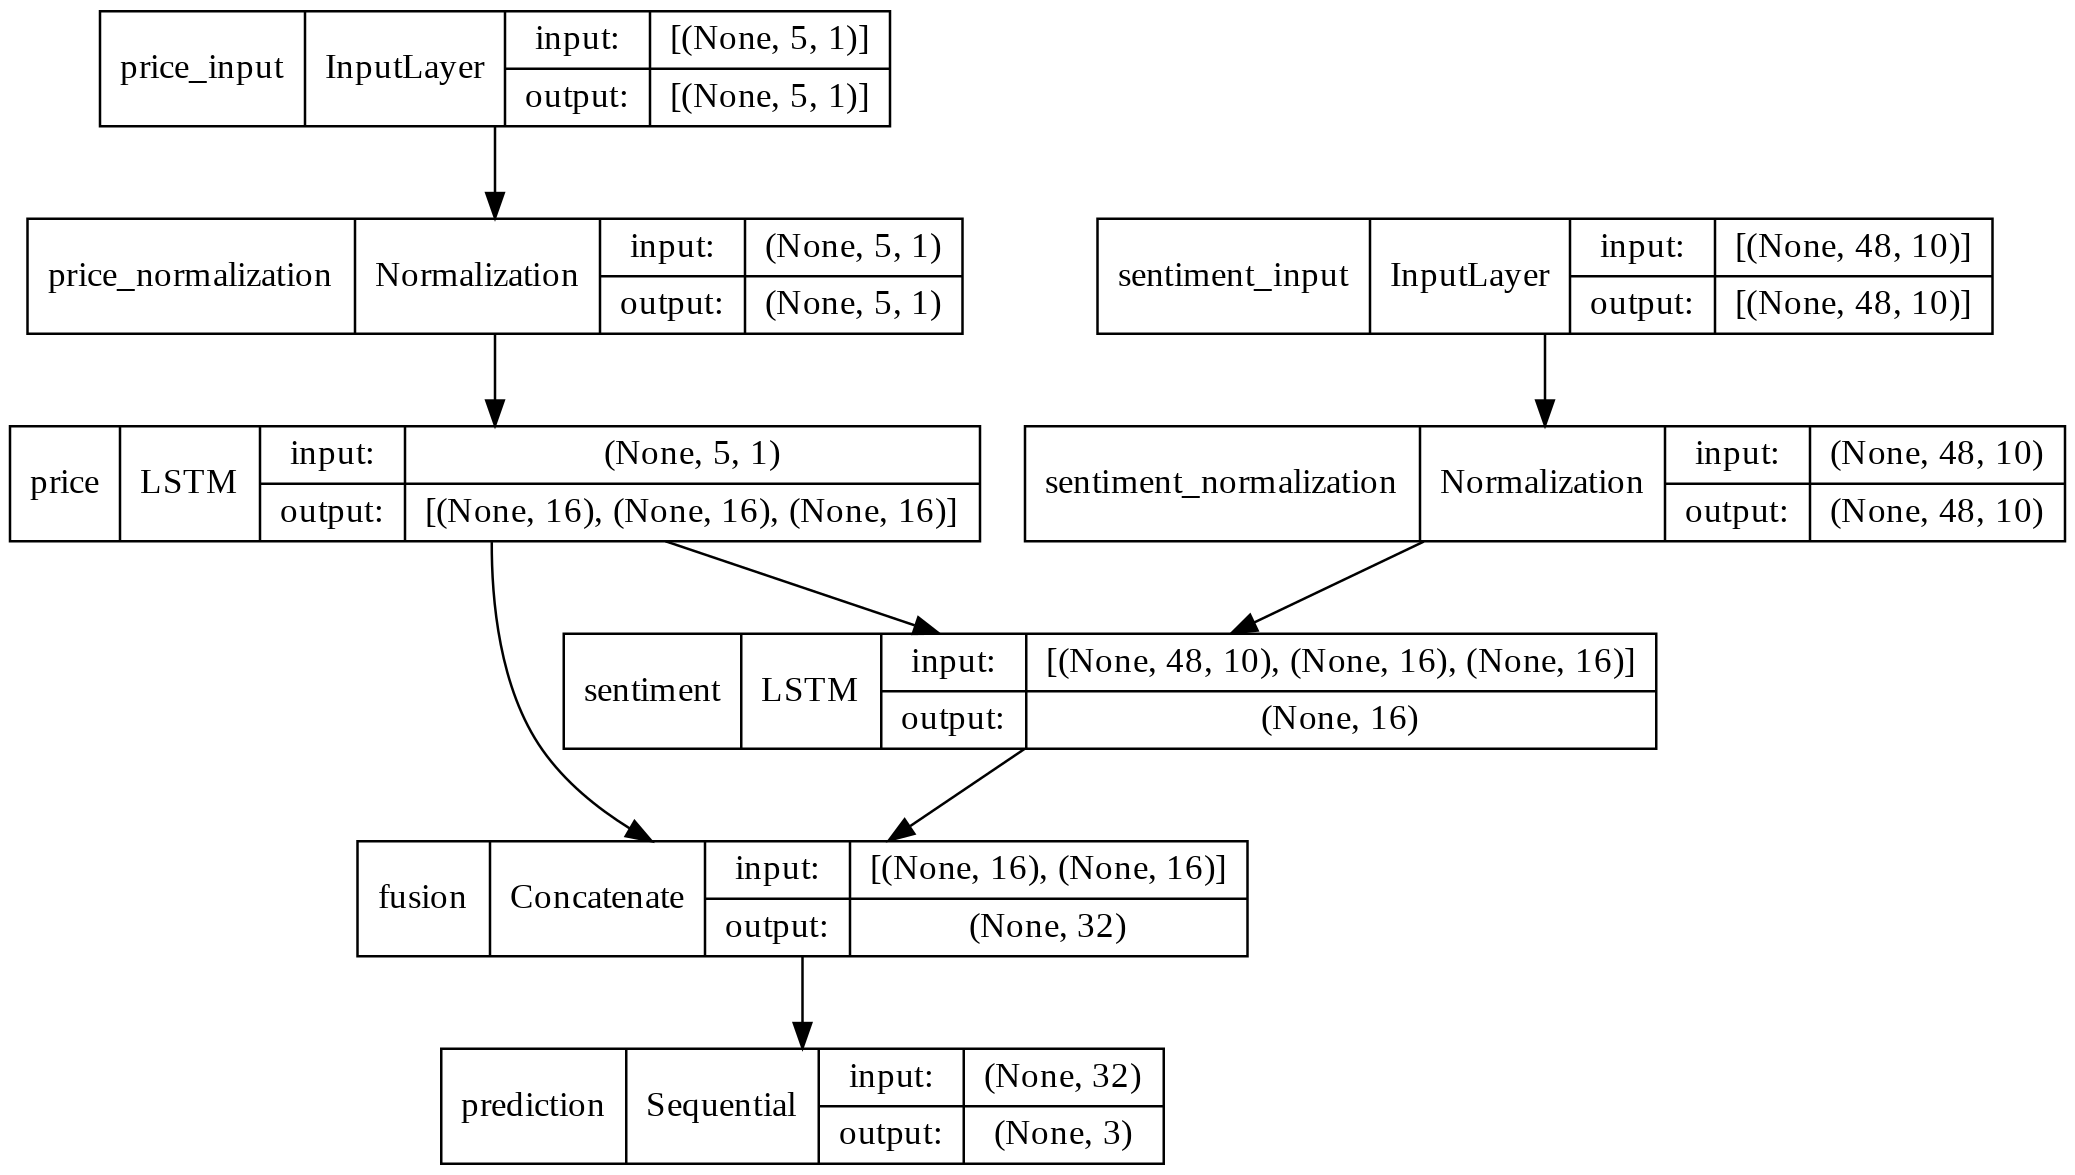

In [ ]:
keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=180,
)

#### Entrenamiento

In [ ]:
history = model.fit(
    [train_prices, train_features], y_train, 
    epochs = 1000, 
    callbacks = [earlystop_cb], 
    validation_data = [[val_prices, val_features], y_val]
).history

Epoch 1/1000
263/263 [==============================] - 12s 15ms/step - loss: 1.1044 - val_loss: 1.0872
Epoch 2/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0717 - val_loss: 1.0595
Epoch 3/1000
263/263 [==============================] - 3s 12ms/step - loss: 1.0570 - val_loss: 1.0543
Epoch 4/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0495 - val_loss: 1.0407
Epoch 5/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0448 - val_loss: 1.0609
Epoch 6/1000
263/263 [==============================] - 4s 14ms/step - loss: 1.0406 - val_loss: 1.0622
Epoch 7/1000
263/263 [==============================] - 3s 13ms/step - loss: 1.0378 - val_loss: 1.0482
Epoch 8/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0369 - val_loss: 1.0519
Epoch 9/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0348 - val_loss: 1.0340
Epoch 10/1000
263/263 [==============================] - 3s 11ms/step - 

##### Visualización

In [ ]:
x = list(range(len(history['loss'])))

fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = history['loss'])) \
   .add_trace(go.Scatter(x = x, y = history['val_loss']))

fig.show()

#### Métricas

In [ ]:
evaluate_model(model, [[train_prices, train_features], y_train], [[val_prices, val_features], y_val], [[test_prices, test_features], y_test])

train cross_entropy =  1.012297511100769
  val cross_entropy =  1.0272339582443237
 test cross_entropy =  1.0360366106033325


### Segunda Arquitectura

#### Arquitectura

In [ ]:
price_input = layers.Input(shape = (len_prices,), name = 'price_input')

price_layer = keras.models.Sequential(
    [
     layers.Normalization(name = 'price_normalization'), 
     layers.Dense(16, activation = 'tanh'), 
     layers.Dense(16, activation = 'relu'),
    ], 
    name = 'price'
)

price_output = price_layer(price_input)

sentiment_input = layers.Input(shape = (len_features, n_features), name = 'sentiment_input')
sentiment_normalization = layers.Normalization(name = 'sentiment_normalization', axis = 1)
sentiment_lstm = layers.LSTM(16, name = 'sentiment')

sentiment_normalized = sentiment_normalization(sentiment_input)
sentiment_output = sentiment_lstm(sentiment_normalized)

fusion = layers.Concatenate(name = 'fusion')([sentiment_output, price_output])


prediction_layer = keras.models.Sequential(
    [
     layers.Dense(32, activation = 'sigmoid'), 
     layers.Dense(32, activation = 'sigmoid'), 
     layers.Dense(32, activation = 'sigmoid'), 
     layers.Dense(3, activation = 'softmax')
    ], 
    name = 'prediction'
)
prediction_output = prediction_layer(fusion)

#### Modelo

In [ ]:
model_2 = keras.Model([price_input, sentiment_input], prediction_output)

model_2.compile(
    loss = 'categorical_crossentropy'
)

model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentiment_input (InputLayer)   [(None, 48, 10)]     0           []                               
                                                                                                  
 sentiment_normalization (Norma  (None, 48, 10)      97          ['sentiment_input[0][0]']        
 lization)                                                                                        
                                                                                                  
 price_input (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 sentiment (LSTM)               (None, 16)           1728        ['sentiment_normalization[0

##### Visualización

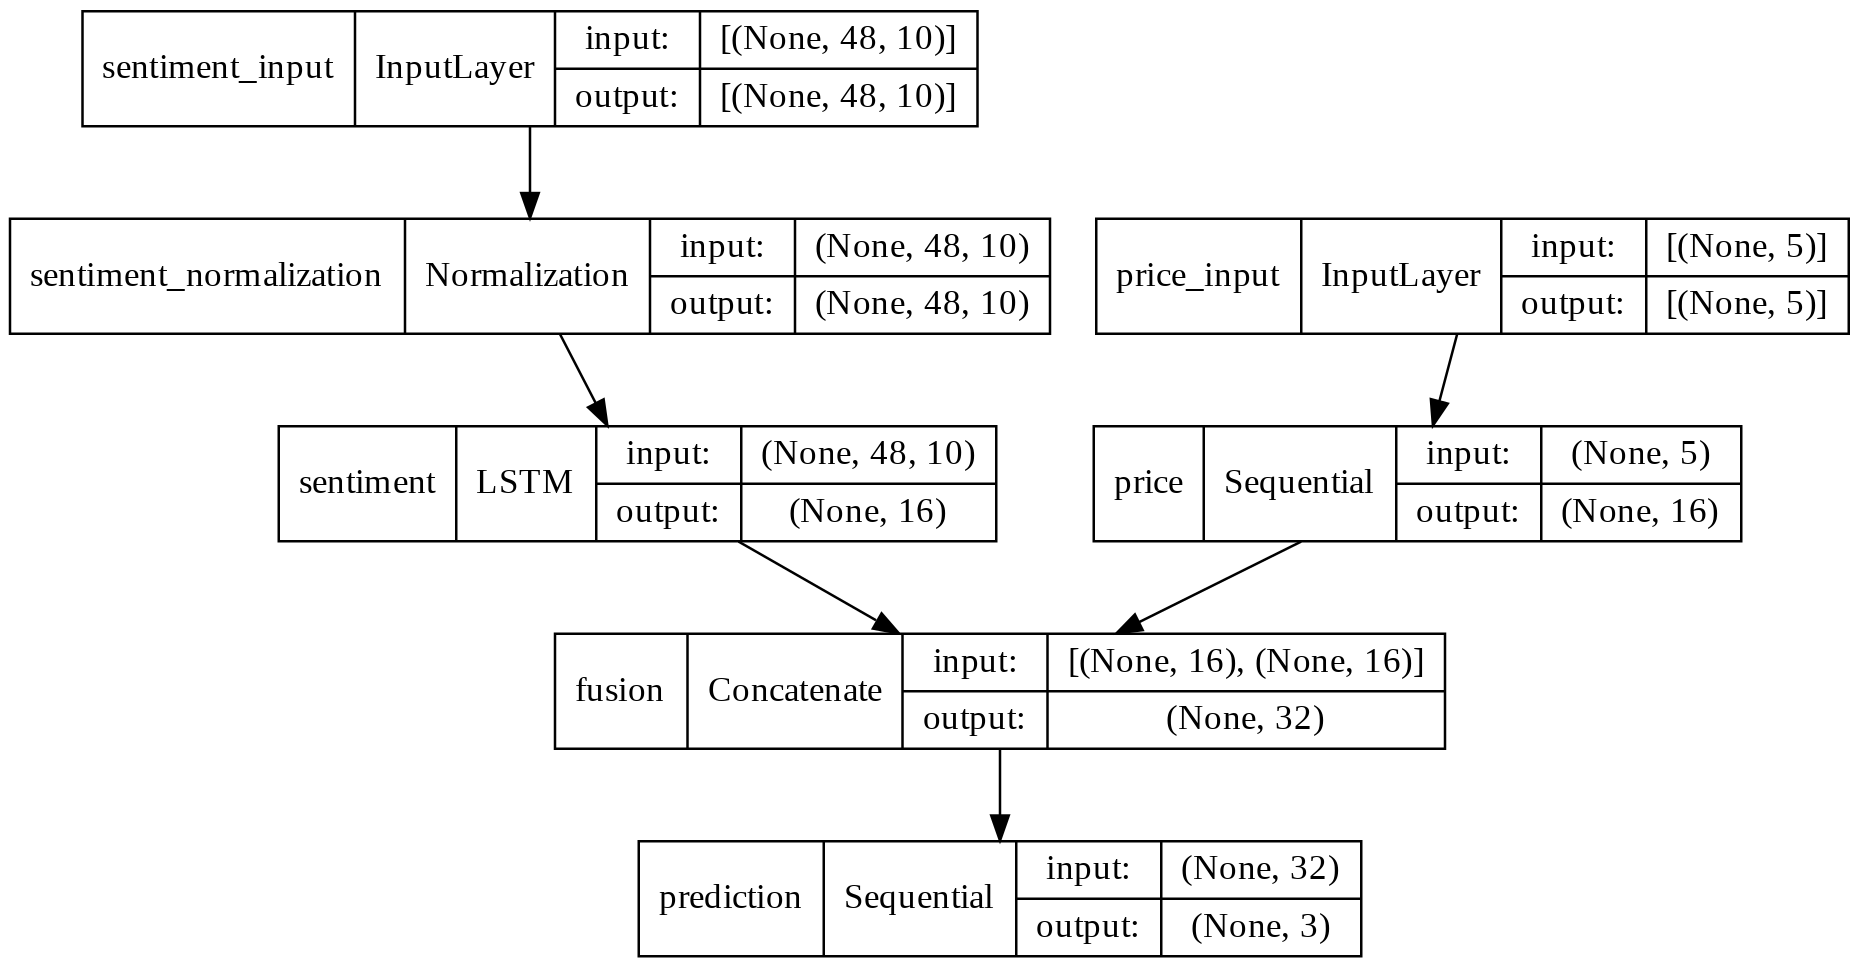

In [ ]:
keras.utils.plot_model( 
    model_2,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=180,
)

#### Entrenamiento

In [ ]:
history = model_2.fit(
    [train_prices, train_features], y_train, 
    epochs = 1000, 
    callbacks = [earlystop_cb], 
    validation_data = [[val_prices, val_features], y_val]
).history

Epoch 1/1000
263/263 [==============================] - 6s 12ms/step - loss: 1.0995 - val_loss: 1.0965
Epoch 2/1000
263/263 [==============================] - 3s 10ms/step - loss: 1.0802 - val_loss: 1.0566
Epoch 3/1000
263/263 [==============================] - 3s 10ms/step - loss: 1.0477 - val_loss: 1.0450
Epoch 4/1000
263/263 [==============================] - 3s 10ms/step - loss: 1.0383 - val_loss: 1.0549
Epoch 5/1000
263/263 [==============================] - 3s 10ms/step - loss: 1.0337 - val_loss: 1.0377
Epoch 6/1000
263/263 [==============================] - 3s 10ms/step - loss: 1.0266 - val_loss: 1.0342
Epoch 7/1000
263/263 [==============================] - 3s 10ms/step - loss: 1.0226 - val_loss: 1.0313
Epoch 8/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0171 - val_loss: 1.0356
Epoch 9/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0147 - val_loss: 1.0318
Epoch 10/1000
263/263 [==============================] - 3s 10ms/step - l

##### Visualización

In [ ]:
x = list(range(len(history['loss'])))

fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = history['loss'])) \
   .add_trace(go.Scatter(x = x, y = history['val_loss'])) \
   .update_layout(hovermode = 'x')

fig.show()

#### Métricas

In [ ]:
evaluate_model(model_2, [[train_prices, train_features], y_train], [[val_prices, val_features], y_val], [[test_prices, test_features], y_test])

train cross_entropy =  0.984365701675415
  val cross_entropy =  1.0256131887435913
 test cross_entropy =  1.032956600189209


### Tercera Arquitectura

#### Arquitectura

In [ ]:
fusion_dim = 8

price_input = layers.Input(shape = (len_prices,), name = 'price_input')

price_layer = keras.models.Sequential(
    [
     layers.Normalization(name = 'price_normalization'), 
     layers.Dense(8, activation = 'tanh'), 
     layers.Dense(8, activation = 'relu'),
     layers.Dense(8, activation = 'tanh'), 
     layers.Dense(fusion_dim, activation = 'relu'),
    ], 
    name = 'price'
)

price_output = price_layer(price_input)

sentiment_input = layers.Input(shape = (len_features, n_features), name = 'sentiment_input')
sentiment_normalization = layers.Normalization(name = 'sentiment_normalization', axis = 1)
sentiment_lstm = layers.LSTM(fusion_dim, name = 'sentiment')

sentiment_normalized = sentiment_normalization(sentiment_input)
sentiment_output = sentiment_lstm(sentiment_normalized)

fusion = layers.Multiply(name = 'hadamard_product')([sentiment_output, price_output])

prediction_layer = keras.models.Sequential(
    [
     layers.Dense(8, activation = 'tanh'), 
     layers.Dense(8, activation = 'relu'), 
     layers.Dense(8, activation = 'sigmoid'), 
     layers.Dense(3, activation = 'softmax')
    ], 
    name = 'prediction'
)
prediction_output = prediction_layer(fusion)

#### Modelo

In [ ]:
model_3 = keras.Model([price_input, sentiment_input], prediction_output)

model_3.compile(
    loss = 'categorical_crossentropy'
)

model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentiment_input (InputLayer)   [(None, 48, 10)]     0           []                               
                                                                                                  
 sentiment_normalization (Norma  (None, 48, 10)      97          ['sentiment_input[0][0]']        
 lization)                                                                                        
                                                                                                  
 price_input (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 sentiment (LSTM)               (None, 8)            608         ['sentiment_normalization[0

##### Visualización

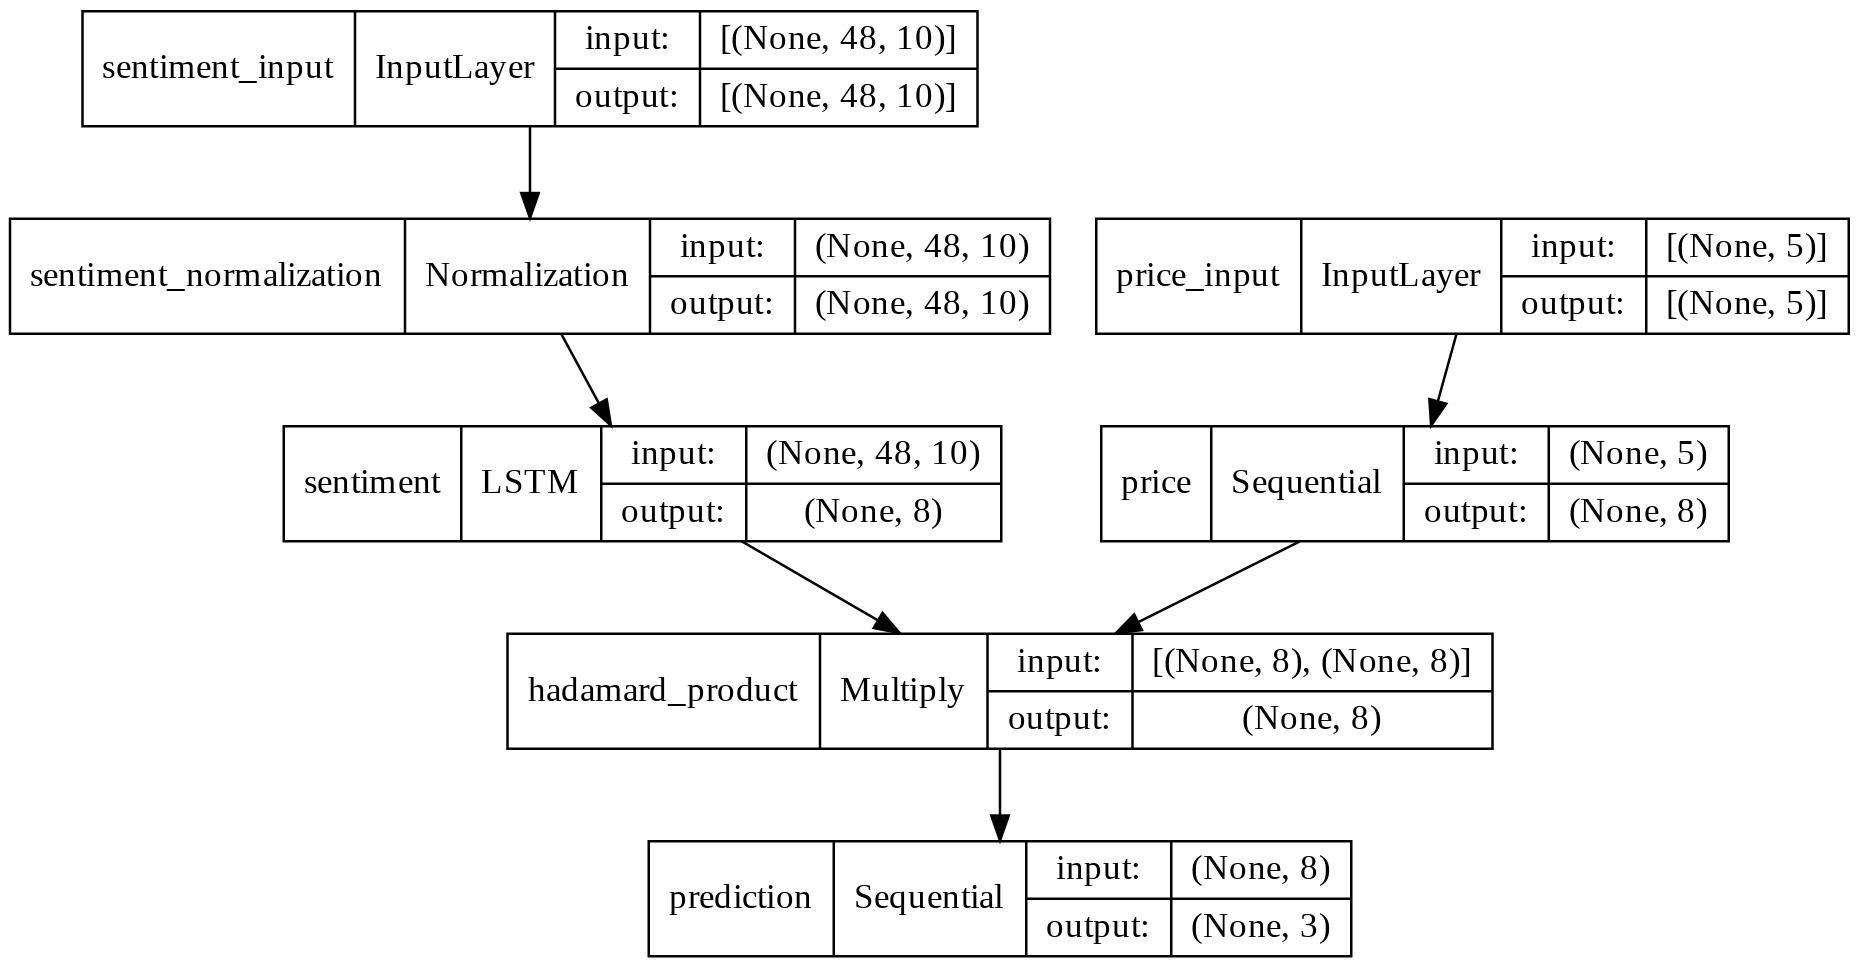

In [ ]:
keras.utils.plot_model( 
    model_3,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=180,
)

#### Entrenamiento

In [ ]:
history = model_3.fit(
    [train_prices, train_features], y_train, 
    epochs = 1000, 
    callbacks = [earlystop_cb], 
    validation_data = [[val_prices, val_features], y_val]
).history

Epoch 1/1000
263/263 [==============================] - 7s 15ms/step - loss: 1.1077 - val_loss: 1.0988
Epoch 2/1000
263/263 [==============================] - 3s 12ms/step - loss: 1.0977 - val_loss: 1.1008
Epoch 3/1000
263/263 [==============================] - 3s 12ms/step - loss: 1.0968 - val_loss: 1.0977
Epoch 4/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0940 - val_loss: 1.0951
Epoch 5/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0855 - val_loss: 1.0839
Epoch 6/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0722 - val_loss: 1.0765
Epoch 7/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0620 - val_loss: 1.0719
Epoch 8/1000
263/263 [==============================] - 3s 12ms/step - loss: 1.0548 - val_loss: 1.0678
Epoch 9/1000
263/263 [==============================] - 3s 11ms/step - loss: 1.0501 - val_loss: 1.0681
Epoch 10/1000
263/263 [==============================] - 3s 11ms/step - l

##### Visualización

In [ ]:
x = list(range(len(history['loss'])))

fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = history['loss'])) \
   .add_trace(go.Scatter(x = x, y = history['val_loss'])) \
   .update_layout(hovermode = 'x')

fig.show()

#### Métricas

In [ ]:
evaluate_model(model_3, [[train_prices, train_features], y_train], [[val_prices, val_features], y_val], [[test_prices, test_features], y_test])

train cross_entropy =  1.026957392692566
  val cross_entropy =  1.0609599351882935
 test cross_entropy =  1.0625256299972534


## Guardando el mejor modelo

In [ ]:
# model_2.save('/content/drive/MyDrive/Cursos/LSTM - Bitcoin v2/best_model.h5')

# Cargar el modelo guardado

In [ ]:
best_model = keras.models.load_model('/content/drive/MyDrive/Cursos/LSTM - Bitcoin v2/best_model.h5')
best_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentiment_input (InputLayer)   [(None, 48, 10)]     0           []                               
                                                                                                  
 sentiment_normalization (Norma  (None, 48, 10)      97          ['sentiment_input[0][0]']        
 lization)                                                                                        
                                                                                                  
 price_input (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 sentiment (LSTM)               (None, 16)           1728        ['sentiment_normalization[0

In [ ]:
evaluate_model(best_model, [[train_prices, train_features], y_train], [[val_prices, val_features], y_val], [[test_prices, test_features], y_test])

train cross_entropy =  0.984365701675415
  val cross_entropy =  1.0256131887435913
 test cross_entropy =  1.032956600189209


# Resumen

Respecto a la segunda arquitectura:

1. Fue la que tuvo mejores resultados con entropía cruzada de $0.9843$, $1.0256$ y $1.0329$ para los conjuntos de entrenamiento, validación y prueba, respectivamente.
2. Tardó menos épocas en entrenar



# Ejercicios

1. Realizar el entrenamiento de la regresión logística mencionada
2. Crear un nuevo modelo ya sea haciendo modificaciones a alguna de las arquitecturas presentes, o comenzando desde cero. Escriba sus observaciones comparando el resultado con el mejor la Segunda Arquitectura. Como sugerencia, puede probar cambiando los datos de entrada, las capas de las redes secuenciales, la fusión de los datos, agregando regularización o dropout, callbacks, etc. 
3. ¿Cómo predeciría nuevos valores?


# TODO

- Traducir el contexto del problema y la descripción de los datos